In [21]:
# standard
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# keras/tensorflow
from tqdm.keras import TqdmCallback
import tensorflow as tf

# sklearn
from sklearn import metrics, model_selection
from sklearn.preprocessing import LabelEncoder


# visualisation
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [22]:
# load data
file = 'C:/Users/SMARTech/Downloads/CSA-Data.csv'
df = pd.read_csv(file)
# renaming the columns (as they're little long!)
og_cols = df.columns
new_cols = []
for col in enumerate(og_cols):
    if 'Knowledge' in col[1]:
        new_cols.append('target')
        df.rename({col[1] : 'target'},axis=1, inplace=True)
    else:
        new_cols.append('feature'+str(col[0]))
        df.rename({col[1] : 'feature'+str(col[0])},axis=1, inplace=True)

# original column & new column name mapping 
mapping = dict(zip(og_cols, new_cols))

# label encoding - target
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])
        
# view
print(f"Found {df.shape[0]} records with {df['target'].nunique()} labels")

Found 3002 records with 2 labels


# Target Label Distribution

In [23]:
# visualise distribution
fig = px.histogram(df, x="target", color='target',title='Distribution of Target Labels',
                   hover_data=df.columns,width=700,height=700,opacity=0.6)
fig.show()

# Dataset Split

In [24]:
# split the dataframe into train, validation & test sets [80-15-5]
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.95 * len(df))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2401 training examples
450 validation examples
151 test examples


In [26]:
# custom function to create input pipeline
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    temp = dataframe.copy()
    labels = temp.pop('target')
    temp = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(temp), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

# custom function for preprocessing categorical columns 
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = kr.layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = kr.layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    
    # Encode the integer indices.
    encoder = kr.layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    
    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [27]:
# creating training / validation / test dataset
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
[(train_features, label_batch)] = train_ds.take(1)

C:\Users\SMARTech\AppData\Local\Temp\ipykernel_15708\3052104908.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\SMARTech\AppData\Local\Temp\ipykernel_15708\3052104908.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\SMARTech\AppData\Local\Temp\ipykernel_15708\3052104908.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



# Encode Categorical Data

In [7]:
# empty lists
all_inputs = []
encoded_features = []

# applying category encoding function to every feature column (which in this case is all features)
for col in list(train_features.keys())[0:8]:
    categorical_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
    encoding_layer = get_category_encoding_layer(name=col,dataset=train_ds,
                                               dtype='string',max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Build & Compile Model

In [28]:
# create compile & train
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(8,activation='relu')(x)
output =tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)

# compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

# model summary plot
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Model

In [29]:
# train param
epoch = 50
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# for re-runs
tf.keras.backend.clear_session()
gc.collect()

# train
hist = model.fit(train_ds
                 ,epochs=epoch
                 ,validation_data=val_ds
                 ,shuffle=True
                 ,callbacks=[TqdmCallback(verbose=0),earlyStopping]
                 ,verbose=0)

# view
model_acc = '{:.2%}'.format(hist.history['accuracy'][-1])
model_epoch = len(hist.history['accuracy'])
print(f"\n\nThe model achieved {model_acc} in {model_epoch} epoch(s)")

0epoch [00:00, ?epoch/s]

C:\Users\SMARTech\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:638: UserWarning:

Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.





The model achieved 87.38% in 40 epoch(s)


# Predictions & Metrics

In [36]:
# making prediction on test data
preds = model.predict(test_ds)
y_pred = [round(x[0]) for x in preds]
y_true = test['target']

acc_score = '{:.2%}'.format(metrics.accuracy_score(y_true, y_pred))
print(metrics.classification_report(y_true, y_pred))
print(f"\nAccuracy is : {acc_score}")

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        74
           1       0.87      0.94      0.90        77

    accuracy                           0.89       151
   macro avg       0.90      0.89      0.89       151
weighted avg       0.90      0.89      0.89       151


Accuracy is : 89.40%


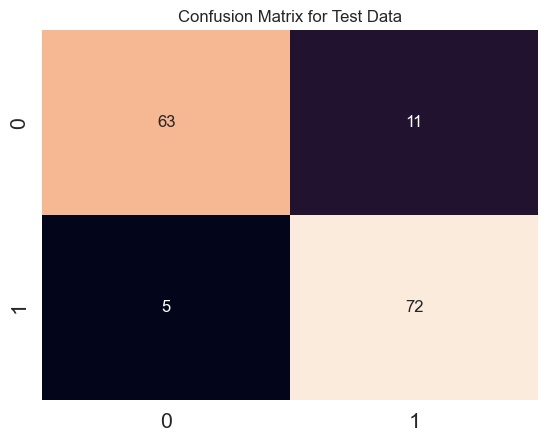

In [31]:
# confusion matrix
cm = metrics.confusion_matrix(np.array(y_true), y_pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cbar=False) # font size
plt.title("Confusion Matrix for Test Data",fontdict={'fontsize': 12})
plt.show()